# Determining monthly extent of waterbodies with Sentinel-2 <img align="right" src="../resources/csiro_easi_logo.png">
* **Products used (from EASI-Asia):** 
[s2_l2a](https://explorer.asia.easi-eo.solutions/products/s2_l2a)
* **Keywords**: data used; sentinel-2, water; extent, analysis; time series, band index; MNDWI; visualisation; animation

## Background
The United Nations have prescribed 17 "Sustainable Development Goals" (SDGs). This notebook attempts to monitor SDG Indicator 6.6.1 - change in the extent of water-related ecosystems. Indicator 6.6.1 has 4 sub-indicators:
>    i. The spatial extent of water-related ecosystems <br>
>    ii. The quantity of water contained within these ecosystems <br>
>    iii. The quality of water within these ecosystems <br>
>    iv. The health or state of these ecosystems <br>

This notebook primarily focuses on the first sub-indicator - spatial extents.

## Description

The notebook demonstrates how to:

1. [Load satellite data over the water body of interest](#Load-cloud-masked-satellite-data)
    - **Select the appropriate EPSG for the AOI** (For bagnladesh, we can use EPSG:32645 (UTM 45N), or EPSG:32646 (UTM 46N))
2. [Calculate the water index MNDWI](#Calculate-the-MNDWI-water-index)
3. [Resample the time-series of MNDWI to monthly medians](#Resample-time-series)
4. [Generate an animation of the water extent time-series](#Animating-time-series)
5. [Calculate and plot a time series of monthly water extent (in square kilometres)](#Calculating-the-extent-of-water)
    - **Export the results of total water extent (km2) to a csv file**
    - **Export the resluts of spatial MNDWI to GeoTiff files**
6. [Find the minimum and maximum water extents in the time-series and plot them](#Determine-minimum-and-maximum-water-extent)
7. [Compare two nominated time-periods, and plot where the water-body extent has changed](#Compare-two-time-periods)

***

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [3]:
%matplotlib inline

# Force GeoPandas to use Shapely instead of PyGEOS
# In a future release, GeoPandas will switch to using Shapely by default.

import git
import sys
import os
os.environ['USE_PYGEOS'] = '0'

repo = '/home/jovyan/easi-notebooks'
if repo not in sys.path: sys.path.append(repo)
from easi_tools import EasiDefaults, notebook_utils
import easi_tools

import datacube
from datacube.utils.rio import configure_s3_access
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import rioxarray
import geopandas as gpd
from IPython.display import Image
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from dask.distributed import Client, LocalCluster
repo = '/home/jovyan/deafrica-sandbox-notebooks/Tools'
if repo not in sys.path: sys.path.append(repo)
from datacube.utils.geometry import Geometry
from deafrica_tools.datahandling import load_ard
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.plotting import display_map, xr_animation
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.areaofinterest import define_area

In [4]:
easi = EasiDefaults()

Successfully found configuration for deployment "asia"


## Set up a Dask cluster

Dask can be used to better manage memory use and conduct the analysis in parallel. 
For an introduction to using Dask with Digital Earth Africa, see the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

To activate Dask, set up the local computing cluster using the cell below.

In [5]:
# Local cluster

# cluster = LocalCluster(n_workers=2, threads_per_worker=4)
# client = Client(cluster)
# display(client)
# dashboard_address = notebook_utils.localcluster_dashboard(client=client,server=easi.hub)
# display(dashboard_address)

# Dask gateway (separate worker machines)
cluster, client = notebook_utils.initialize_dask(use_gateway=True, workers=(1,10))
display(client)

Starting new cluster.


Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: https://hub.asia.easi-eo.solutions/services/dask-gateway/clusters/easihub.3f8c0f94fb1742f580b529605cc08d57/status,


### Connect to the datacube

Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [6]:
dc = datacube.Datacube(app='water_extent')

# Access AWS "requester-pays" buckets
# This is necessary for reading data from most third-party AWS S3 buckets such as for Landsat and Sentinel-2
configure_s3_access(aws_unsigned=False, requester_pays=True, client=client);

### Analysis parameters

The following cell sets the parameters, which define the area of interest and the length of time to conduct the analysis over.

The parameters are:

* `lat`: The central latitude to analyse (e.g. 22).
* `lon` : The central longitude to analyse (e.g. 90).
* `lat_buffer` : The number of degrees to load around the central latitude.
* `lon_buffer` : The number of degrees to load around the central longitude.
* `start_year` and `end_year`: The date range to analyse (e.g. `('2021', '2022')`.

#### Select location
To define the area of interest, there are two methods available:

1. By specifying the latitude, longitude, and buffer. This method requires you to input the central latitude, central longitude, and the buffer value in square degrees around the center point you want to analyze. For example, `lat = 22`, `lon = 90`, and `buffer = 0.1` will select an area with a radius of 0.1 square degrees around the point with coordinates (10.338, -1.055).

2. By uploading a polygon as a `GeoJSON or Esri Shapefile`. If you choose this option, you will need to upload the geojson or ESRI shapefile into the EASI by draging and dropping files to the Jupyter Notebook File Browser (left side). ESRI shapefiles must be uploaded with all the related files `(.cpg, .dbf, .shp, .shx)`. Once uploaded, you can use the shapefile or geojson to define the area of interest. Remember to update the code to call the file you have uploaded.

To use one of these methods, you can uncomment the relevant line of code and comment out the other one. To comment out a line, add the `"#"` symbol before the code you want to comment out. By default, the first option which defines the location using latitude, longitude, and buffer is being used.

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.

The example covers the area of **Amtali**, a municipality in Barguna District in the division of Barisal, Bangladesh

In [7]:
# Method 1: Specify the latitude, longitude, and buffer
# aoi = define_area(lat=22, lon=90 , buffer=0.03)

# Method 2: Use a polygon as a GeoJSON or Esri Shapefile. 
geopolygon_gdf = gpd.read_file('/home/jovyan/EASI_Bangladesh/waterbodies_amtali/amtali_shape/Amtali3.shp') #/home/jovyan/waterbodies_amtali/amtali_shape/Amtali3.shp

# Get the latitude and longitude range of the geopolygon
lat_range = (geopolygon_gdf.total_bounds[1], geopolygon_gdf.total_bounds[3])
lon_range = (geopolygon_gdf.total_bounds[0], geopolygon_gdf.total_bounds[2])


# Define the start year and end year
start_year = '2021-10'
end_year = '2022-04'

In [8]:
lat_range, lon_range

((21.859741210937557, 22.304210662841854),
 (90.02218627929688, 90.37570953369146))

## View the area of Interest on an interactive map
The next cell will display the selected area on an interactive map.
The red border represents the area of interest of the study.
Zoom in and out to get a better understanding of the area of interest.
Clicking anywhere on the map will reveal the latitude and longitude coordinates of the clicked point.

In [9]:
display_map(lon_range, lat_range)

## Load cloud-masked satellite data

The code below will create a query dictionary for our region of interest, and then load Sentinel-2 satellite data.
For more information on loading data, see the [Loading data notebook](../Beginners_guide/03_Loading_data.ipynb).

In [10]:
#Create a query object
query = {
    'x': lon_range,
    'y': lat_range,
    'resolution': (-20, 20),
    'output_crs':'EPSG:32646', # for bagnladesh, we can use EPSG:32645 (UTM 45N), or EPSG:32646 (UTM 46N)
    'time': (start_year, end_year),
    'dask_chunks':{'time':10,'x':200,'y':200}
}

#load Sentinel 2 data
ds = load_ard(dc=dc,
        products=['s2_l2a'],
        measurements=['green','swir_1'],
        mask_filters=[("opening", 3),("dilation", 2)], #improve cloud mask
        group_by='solar_day',
        skip_broken_datasets = True,
        **query)

#print(ds)

display(ds)

 

display(f'Number of bytes: {ds.nbytes}')

#display(xarray_object_size(ds))

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Applying morphological filters to pq mask [('opening', 3), ('dilation', 2)]
Applying pixel quality/cloud mask
Returning 41 time steps as a dask array


<xarray.Dataset>
Dimensions:      (time: 41, y: 2497, x: 1871)
Coordinates:
  * time         (time) datetime64[ns] 2021-10-03T04:42:26.672000 ... 2022-04...
  * y            (y) float64 2.47e+06 2.47e+06 2.469e+06 ... 2.42e+06 2.42e+06
  * x            (x) float64 1.922e+05 1.922e+05 ... 2.296e+05 2.296e+05
    spatial_ref  int32 32646
Data variables:
    green        (time, y, x) float32 dask.array<chunksize=(10, 200, 200), meta=np.ndarray>
    swir_1       (time, y, x) float32 dask.array<chunksize=(10, 200, 200), meta=np.ndarray>
Attributes:
    crs:           EPSG:32646
    grid_mapping:  spatial_ref

'Number of bytes: 1532414212'

### Clip the datasets to the shape of the area of interest
A geopolygon represents the bounds and not the actual shape because it is designed to represent the extent of the geographic feature being mapped, rather than the exact shape. In other words, the geopolygon is used to define the outer boundary of the area of interest, rather than the internal features and characteristics.

Clipping the data to the exact shape of the area of interest is important because it helps ensure that the data being used is relevant to the specific study area of interest. While a geopolygon provides information about the boundary of the geographic feature being represented, it does not necessarily reflect the exact shape or extent of the area of interest.

In [11]:
#Rasterise the area of interest polygon
aoi_raster = xr_rasterize(gdf=geopolygon_gdf, da=ds, crs=ds.crs)
#Mask the dataset to the rasterised area of interest
ds = ds.where(aoi_raster == 1)

## Calculate the MNDWI water index

In [12]:
# Calculate the chosen vegetation proxy index and add it to the loaded data set
ds = calculate_indices(ds=ds, index='MNDWI', satellite_mission='s2', drop=True)

Dropping bands ['green', 'swir_1']


## Resample time series

Due to many factors (e.g. cloud obscuring the region, missed cloud cover in the fmask layer) the data will be gappy and noisy. Here, we will resample the data to ensure we working with a consistent time-series.

To do this we resample the data to seasonal time-steps using medians

These calculations will take several minutes to complete as we will run .compute(), triggering all the tasks we scheduled above and bringing the arrays into memory.


In [13]:
%%time
sample_frequency='M'  # quarterly starting in DEC, i.e. seasonal
# sample_frequency = 'ME-OCT'

#resample using medians
# print('calculating MNDWI seasonal medians...')
print('calculating MNDWI monthly medians...')
mndwi = ds['MNDWI'].resample(time=sample_frequency).median().compute()

calculating MNDWI monthly medians...
CPU times: user 1.81 s, sys: 141 ms, total: 1.95 s
Wall time: 7min 10s


### Facet plot the MNDWI time-steps

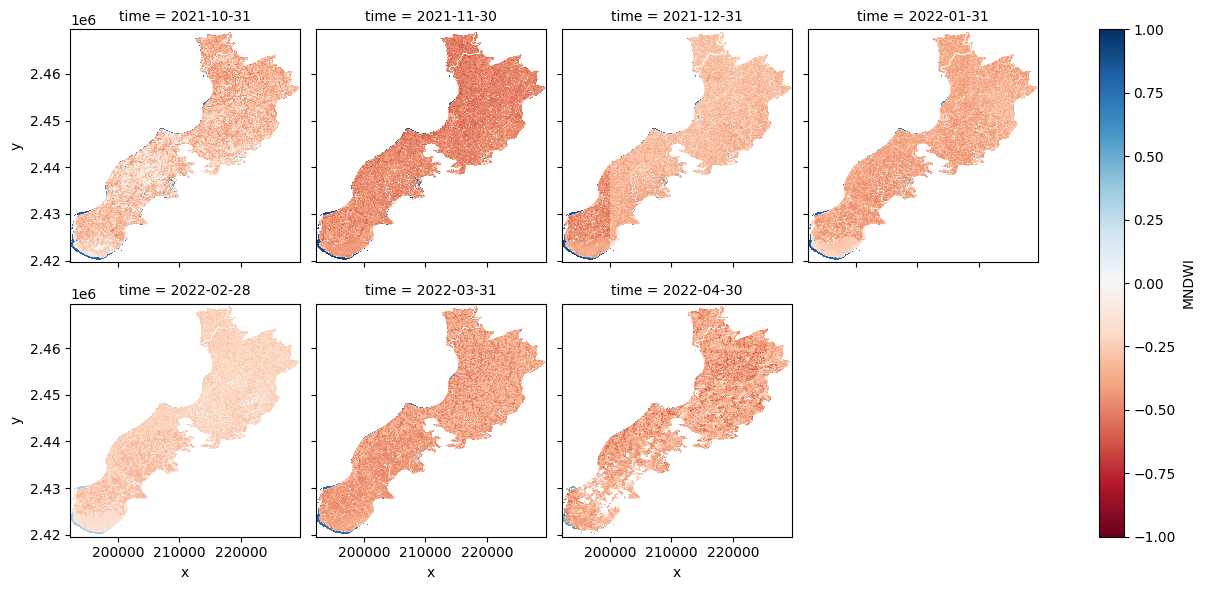

In [14]:
mndwi.plot(col='time', col_wrap=4, cmap='RdBu', vmax=1, vmin=-1);

## Animating time series
In the next cell, we plot the dataset we loaded above as an animation GIF, using the [`xr_animation`](../Frequently_used_code/Animated_timeseries.ipynb) function.
The `output_path` will be saved in the directory where the script is found and you can change the names to prevent files overwrite.

Exporting animation to water_extent.gif


  0%|          | 0/7 (0.0 seconds remaining at ? frames/s)

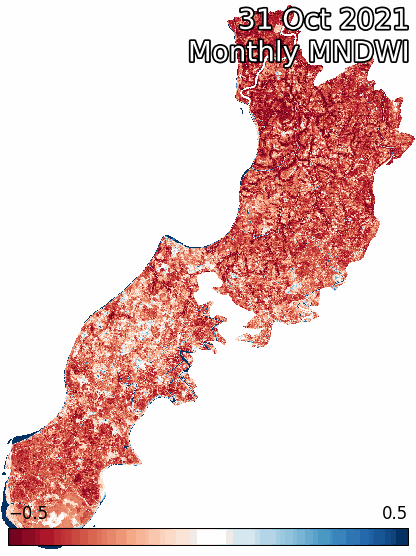

In [15]:
out_path = 'water_extent.gif'

xr_animation(ds=mndwi.to_dataset(name='MNDWI'), 
             output_path=out_path,
             bands = ['MNDWI'],
             show_text = 'Monthly MNDWI',
             interval=500, 
             width_pixels=300,
             show_colorbar=True,
             imshow_kwargs={'cmap':'RdBu','vmin': -0.5, 'vmax': 0.5},
             colorbar_kwargs={'colors': 'black'}
            )

# Plot animated gif
plt.close()
Image(filename=out_path)

## Calculate the area per pixel
The number of pixels can be used for the area of the waterbody if the pixel area is known. 
Run the following cell to generate the necessary constants for performing this conversion.

In [16]:
pixel_length = query["resolution"][1]  # in metres
m_per_km = 1000  # conversion from metres to kilometres
area_per_pixel = pixel_length**2 / m_per_km**2

## Calculating the extent of water

Calculates the area of pixels classified as water (if MNDWI is > 0, then water)

In [17]:
water = mndwi.where(mndwi > 0, np.nan)
area_ds = water.where(np.isnan(water),1)
ds_valid_water_area = area_ds.sum(dim=['x', 'y']) * area_per_pixel
display(ds_valid_water_area)

<xarray.DataArray 'MNDWI' (time: 7)>
array([34.238   , 14.748799, 16.6756  , 15.5576  , 21.183199, 11.5036  ,
        9.2064  ], dtype=float32)
Coordinates:
    spatial_ref  int32 32646
  * time         (time) datetime64[ns] 2021-10-31 2021-11-30 ... 2022-04-30

### Plot monthly time series from the `Start year` to `End year`

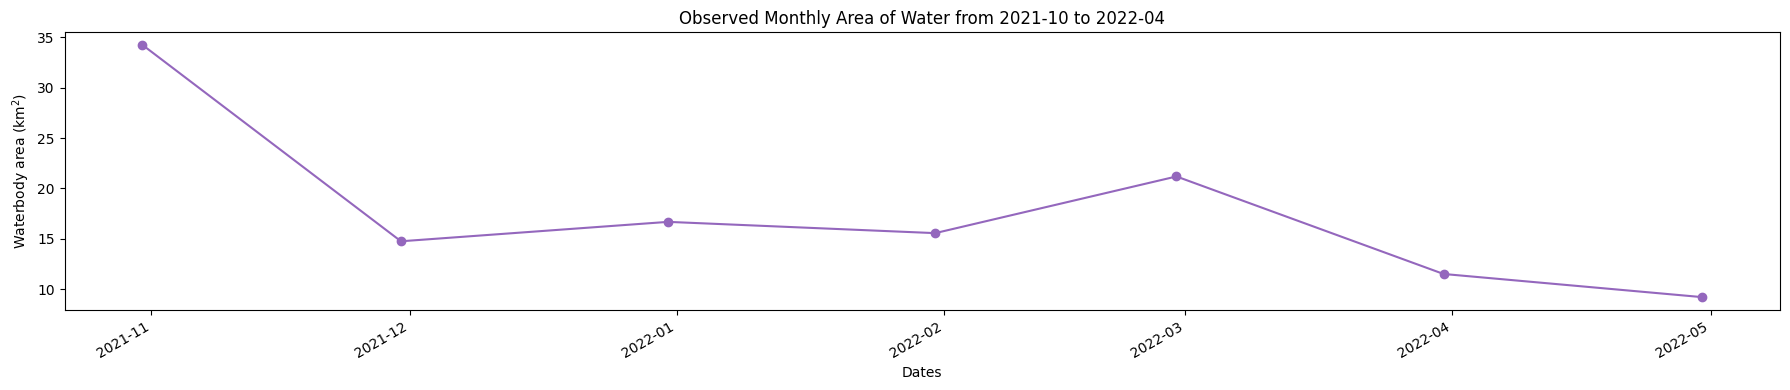

In [18]:
plt.figure(figsize=(18, 4))
ds_valid_water_area.plot(marker='o', color='#9467bd')
# plt.title(f'Observed Seasonal Area of Water from {start_year} to {end_year}')
plt.title(f'Observed Monthly Area of Water from {start_year} to {end_year}')
plt.xlabel('Dates')
plt.ylabel('Waterbody area (km$^2$)')
plt.tight_layout()

### Export Time series results (water extent in km2) to csv

In [20]:
out_path = '/home/jovyan/EASI_Bangladesh/waterbodies_amtali/water_extent_km2.csv'
ds_df = ds_valid_water_area.drop_vars('spatial_ref').to_dataframe().reset_index().rename({'time':'date', 'MNDWI':'Water_extent_km2'}, axis = 1)
ds_df.to_csv(out_path, index=False)

### Export MNDWI to GeoTiff files

In [21]:
for istep in mndwi.time.values:
    mndwi_step = mndwi.sel(time = istep)
    out_filename = f'/home/jovyan/EASI_Bangladesh/waterbodies_amtali/mndwi_{str(istep)[:10]}.tif' 
    mndwi_step.rio.to_raster(out_filename) # export "mndwi_yyyy-mm-dd.tif" to the working directory

## Determine minimum and maximum water extent
The next cell extract the Minimum and Maximum extent of water from the dataset using the `min` and `max` functions, we then add the dates to an `xarray.DataArray`.

In [22]:
min_water_area_date, max_water_area_date =  min(ds_valid_water_area), max(ds_valid_water_area)
time_xr = xr.DataArray([min_water_area_date.time.values, max_water_area_date.time.values], dims=["time"])

print(time_xr)

<xarray.DataArray (time: 2)>
array(['2022-04-30T00:00:00.000000000', '2021-10-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Dimensions without coordinates: time


### Plot the dates when the min and max water extent occur
Plot water classified pixel for the two dates where we have the minimum and maximum surface water extent.

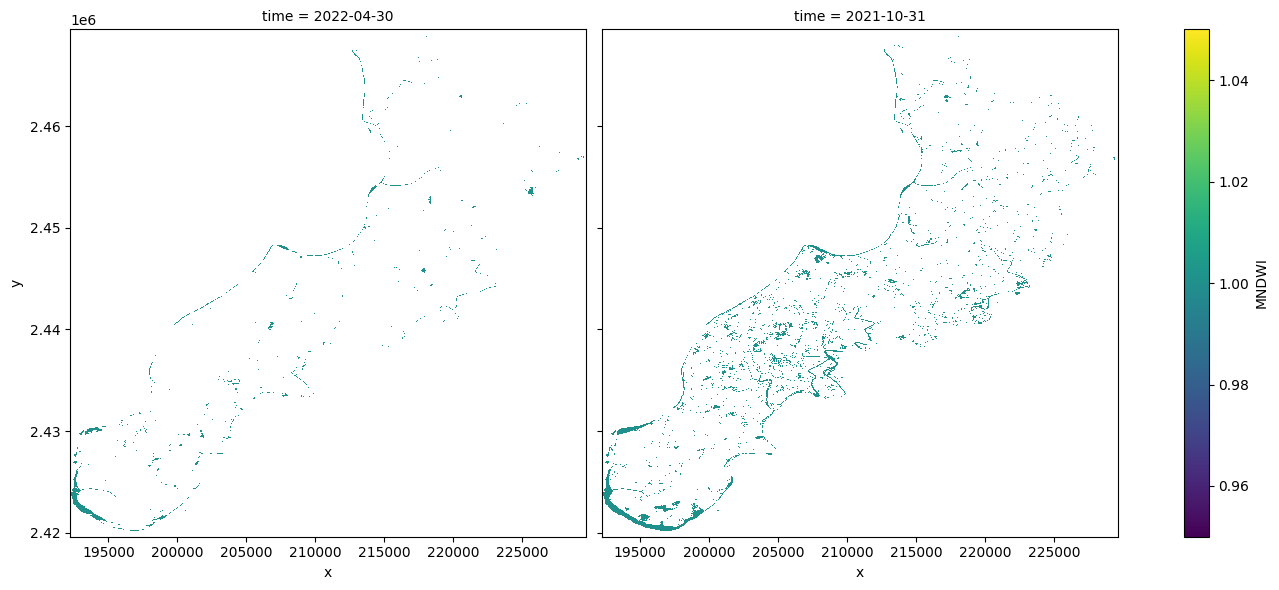

In [23]:
area_ds.sel(time=time_xr).plot.imshow(col="time", col_wrap=2, figsize=(14, 6));

## Compare two time periods
The following cells determine the maximum extent of water for two different years. 
* `baseline_year` : The baseline year for the analysis
* `analysis_year` : The year to compare to the baseline year

In [24]:
baseline_time = '2021-10-01'
analysis_time = '2022-04-01'

baseline_ds, analysis_ds = ds_valid_water_area.sel(time=baseline_time, method ='nearest'),ds_valid_water_area.sel(time=analysis_time, method ='nearest')

A new dataArray is created to store the new date from the `maximum water extent` for the two years

In [25]:
time_xr = xr.DataArray([baseline_ds.time.values, analysis_ds.time.values], dims=["time"])

## Plotting

Plot water extent of the MNDWI product for the two chosen periods.

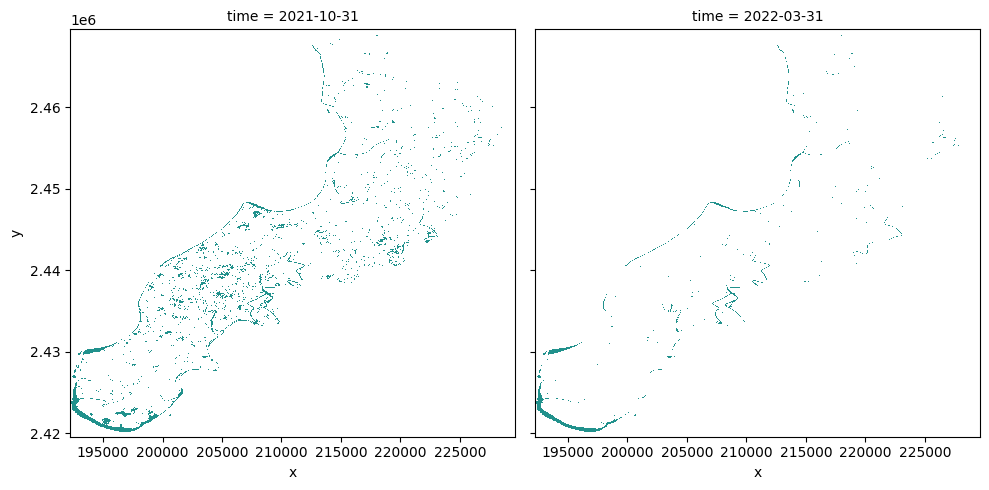

In [26]:
area_ds.sel(time=time_xr).plot(col="time", col_wrap=2, robust=True, figsize=(10, 5), cmap='viridis', add_colorbar=False);

## Calculating the change for the two nominated periods
The cells below calculate the amount of water gain, loss and stable for the two periods

In [27]:
# The two period Extract the two periods(Baseline and analysis) dataset from
ds_selected = area_ds.where(area_ds == 1, 0).sel(time=time_xr)

analyse_total_value = ds_selected[1]
change = analyse_total_value - ds_selected[0]

water_appeared = change.where(change == 1)
permanent_water = change.where((change == 0) & (analyse_total_value == 1))
permanent_land = change.where((change == 0) & (analyse_total_value == 0))
water_disappeared = change.where(change == -1)



The cell below calculate the area of water extent for water_loss, water_gain, permanent water and land 

In [28]:
total_area = analyse_total_value.count().values * area_per_pixel
water_apperaed_area = water_appeared.count().values * area_per_pixel
permanent_water_area = permanent_water.count().values * area_per_pixel
water_disappeared_area = water_disappeared.count().values * area_per_pixel

## Plotting
The water variables are plotted to visualised the result

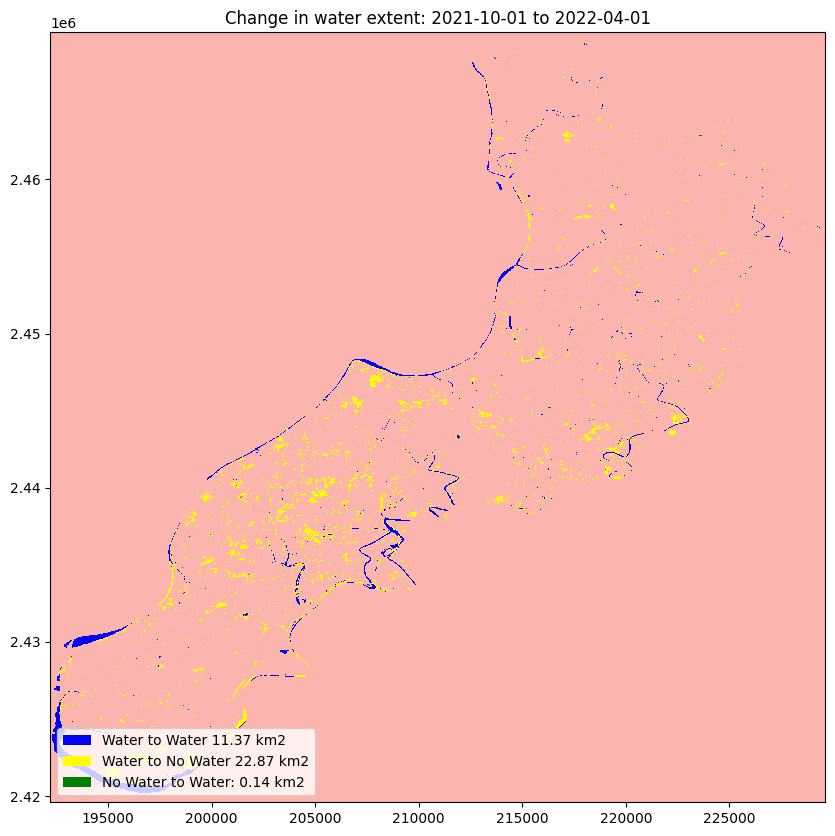

In [29]:
water_appeared_color = "Green"
water_disappeared_color = "Yellow"
stable_color = "Blue"
land_color = "Brown"

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ds_selected[1].plot.imshow(cmap="Pastel1",
                                       add_colorbar=False,
                                       add_labels=False,
                                       ax=ax)
water_appeared.plot.imshow(
    cmap=ListedColormap([water_appeared_color]),
    add_colorbar=False,
    add_labels=False,
    ax=ax,
)
water_disappeared.plot.imshow(
    cmap=ListedColormap([water_disappeared_color]),
    add_colorbar=False,
    add_labels=False,
    ax=ax,
)
permanent_water.plot.imshow(cmap=ListedColormap([stable_color]),
                            add_colorbar=False,
                            add_labels=False,
                            ax=ax)

plt.legend(
    [
        Patch(facecolor=stable_color),
        Patch(facecolor=water_disappeared_color),
        Patch(facecolor=water_appeared_color),
        Patch(facecolor=land_color),
    ],
    [
        f"Water to Water {round(permanent_water_area, 2)} km2",
        f"Water to No Water {round(water_disappeared_area, 2)} km2",
        f"No Water to Water: {round(water_apperaed_area, 2)} km2",
    ],
    loc="lower left",
)

plt.title("Change in water extent: " + baseline_time + " to " + analysis_time);

## Next steps


Return to the "Analysis parameters" section, modify some values (e.g. `latitude`, `longitude`, `start_year`, `end_year`) and re-run the analysis.
You can use the interactive map in the "View the selected location" section to find new central latitude and longitude values by panning and zooming, and then clicking on the area you wish to extract location values for.
You can also use Google maps to search for a location you know, then return the latitude and longitude values by clicking the map.

Change the year also in "Compare Two Time Periods - a Baseline and an Analysis" section, (e.g. `base_year`, `analyse_year`) and re-run the analysis.

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [26]:
print(datacube.__version__)

1.8.16


**Last Tested:**

In [27]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2024-06-06'

2024-06-06 06:44:37,368 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
